# Generating Initial Populations

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Sequences

Below are some examples of how sequences can be generated using popular random number generation tools.

### Pseudo-random sampling

In [2]:
# Generate 200 "random" numbers
np.random.seed(42)
N=200 # number of samples
P_random_pseudo=np.random.rand(N,N) 

This method is "pseudo"-random as it is actually completely deterministic, if you know some key information. Both `random.random` and `numpy.random` use the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). Because new values are generated using a list of old values, sufficient observations of "random" data allows prediction of future values. Also, the same "random" values can be generated simply by using the same seed.

### Generalized Halton Number Generator

In [3]:
# Sampling using Generalized Halton Number Quasi-random Generator
# !pip install ghalton
import ghalton
sequencer = ghalton.GeneralizedHalton(7,23)
P_random_quasi = np.array(sequencer.get(N))

As is evident in the summary graph at the end of this page, the [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) has many disadvantages. Depending on the input parameters, results could show overt correlation, or at least uneven sampling. In this example, we can see some obvious diagonal bands forming, as well as patterns of blank space.

### Box-Muller Transform

In [4]:
# Sampling using Box-Muller 
# 1. generate uniformly distributed values between 0 and 1
u1 = np.random.uniform(size=(N))
u2 = np.random.uniform(size=(N))

# 2. Tranform u1 to s
ss = -np.log(u1)

# 3. Transform u2 to theta
thetas = 2*math.pi*u2

# 4. Convert s to r
rs = np.sqrt(2*ss)

# 5. Calculate x and y from r and theta
P_BM_x, P_BM_y = rs*np.cos(thetas), rs*np.sin(thetas)

One of the drawbacks of the [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is the tendency for values to cluster around the mean. This has to do with 32-bit integers and how numbers are represented by processors. Additionally, calculating the square root (step 4) can be costly.

### Central Limit Theorem

In [5]:
# Sampling using the Central Limit Theorem
from scipy import stats
import random

P_CLT_x=[2.0 * math.sqrt(N) * (sum(random.randint(0,1) for x in range(N)) / N - 0.5) for x in range(N)]
P_CLT_y=[2.0 * math.sqrt(N) * (sum(random.randint(0,1) for x in range(N)) / N - 0.5) for x in range(N)]

### Sobol Sequence

In [6]:
# Sobol low-discrepancy-sequence (LDS)
# !pip install sobol_seq
import sobol_seq
P_sobel=sobol_seq.i4_sobol_generate(2,N)

### Latin Hypercube Sampling

In [7]:
# Latin Hypercube sampling
# !pip install pyDOE
from pyDOE import *
from scipy.stats.distributions import norm
P_LHS=lhs(2, samples=N, criterion='center')

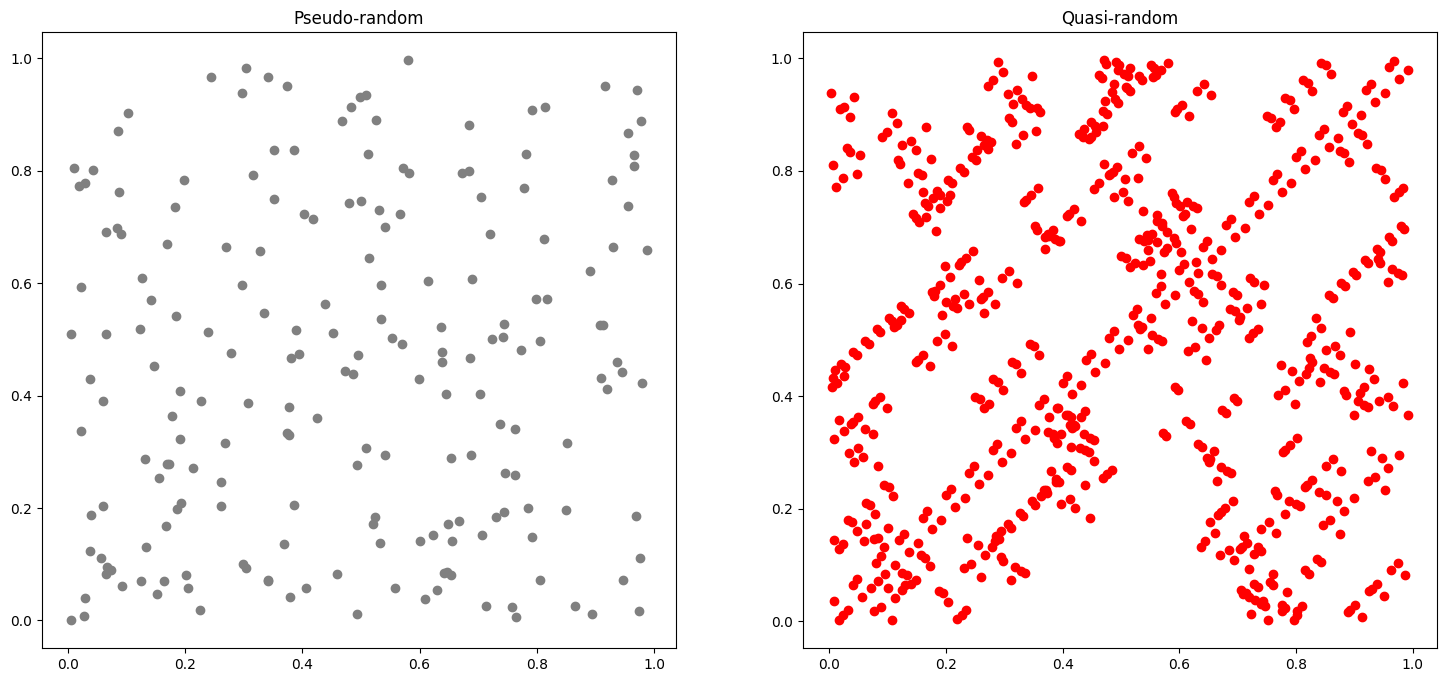

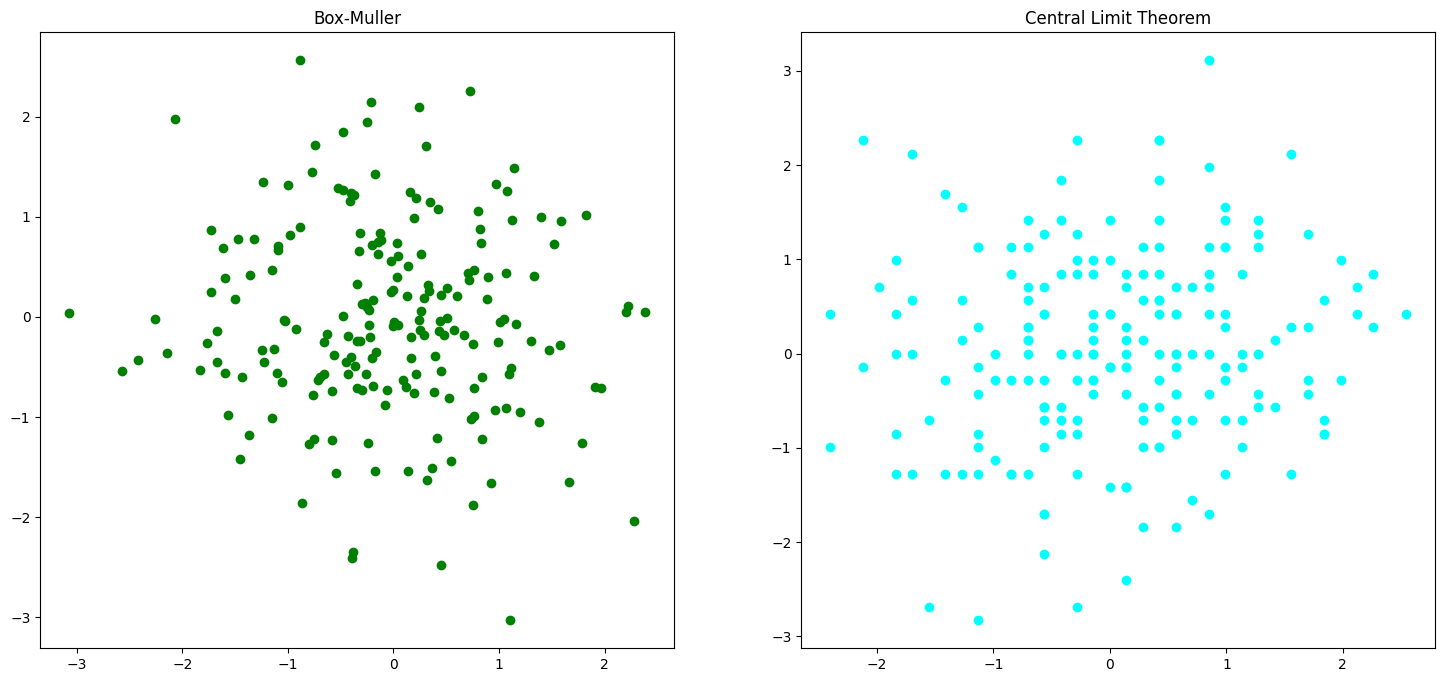

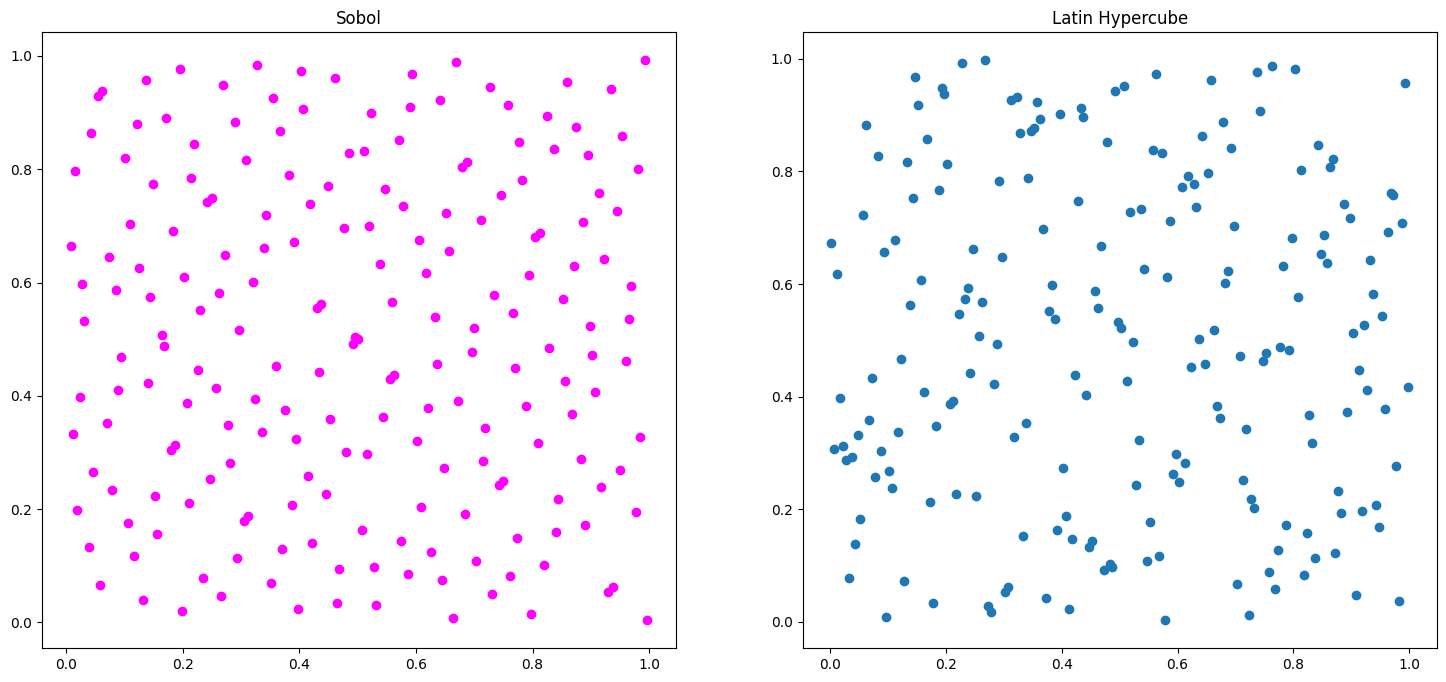

In [8]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8))
f, (ax3,ax4) = plt.subplots(ncols=2, figsize=(18,8))
f, (ax5, ax6) = plt.subplots(ncols=2, figsize=(18,8))
ax1.scatter(P_random_pseudo[:,0], P_random_pseudo[:,1], color="gray")
ax2.scatter(P_random_quasi[:100], P_random_quasi[100:], color="red")
ax3.scatter(P_BM_x, P_BM_y, color="green")
ax4.scatter(P_CLT_x, P_CLT_y, color="cyan")
ax5.scatter(P_sobel[:,0], P_sobel[:,1], color="magenta")
ax6.plot(P_LHS[:,0], P_LHS[:,1], "o")
                          
ax1.set_title("Pseudo-random")
ax2.set_title("Quasi-random")
ax3.set_title("Box-Muller")
ax4.set_title("Central Limit Theorem")
ax5.set_title("Sobol")
ax6.set_title("Latin Hypercube")

# plt.savefig('CH07_F02.png', format='png', dpi=300)

## Permutations

Random permutations can also be generated for existing datasets. Below are a few examples.

### `np.random.permutation`

In [9]:
# randomly permute a sequence, or return a permuted range.
per1=np.random.permutation(10)
print(per1)

[5 4 1 0 8 6 7 9 2 3]


### `np.shuffle`

In [10]:
# another method
per2 = np.array([5, 4, 9, 0, 1, 2, 6, 8, 7, 3])
np.random.shuffle(per2)
print(per2)

[8 2 0 5 6 7 1 9 4 3]


### Initial Population as real-value permutations

In [11]:
# population of initial solution as real-value permuations 
pop_init = np.arange(50).reshape((10,5))
np.random.permutation(pop_init)

array([[45, 46, 47, 48, 49],
       [ 5,  6,  7,  8,  9],
       [30, 31, 32, 33, 34],
       [40, 41, 42, 43, 44],
       [ 0,  1,  2,  3,  4],
       [20, 21, 22, 23, 24],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [25, 26, 27, 28, 29],
       [35, 36, 37, 38, 39]])

### Initial Population as binary permutations

In [12]:
# population of initial solution as binary permutations 
from itertools import combinations
size=5 # number of bits in the binary string
ones=2 # number of ones in each binary string

for pos in map(set, combinations(range(size), ones)):
     print([int(i in pos) for i in range(size)], sep='\n')

[1, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 1, 0, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 1]


## Example: Generating a random route between two points

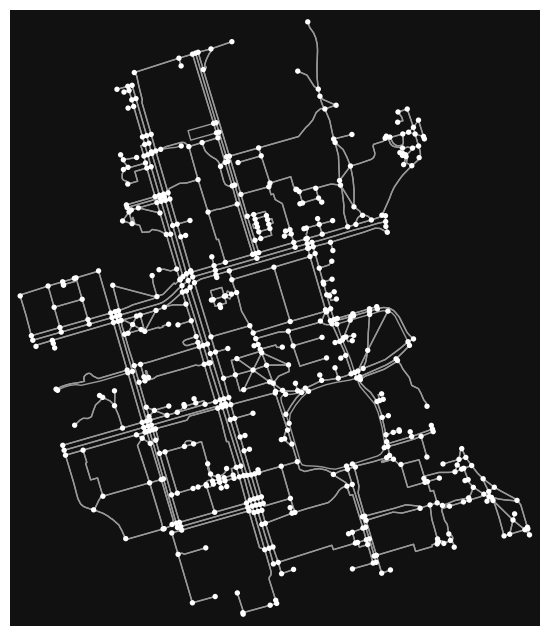

In [13]:
import osmnx as ox
import random
from collections import deque

G = ox.graph_from_place("University of Toronto")
fig, ax = ox.plot_graph(G)

In [14]:
from optalgotools.structures import Node

# this is just a typical graph search with shuffled frontier
def randomized_search(G, source, destination):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = destination)
    
    route = [] 
    frontier = deque([origin])
    explored = set()
    while frontier:
        node = random.choice(frontier)   # here is the randomization part
        frontier.remove(node)
        explored.add(node.osmid)

        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    return route
                frontier.append(child)

    raise Exception("destination and source are not on same component")

The function above modifies a typical graph search algorithm by scrambling the frontier nodes. This means that candidates for expansion are "random", which means different routes are yielded when called repeatedly.

In [15]:
# generate random route between 2 nodes 
random_route = randomized_search(G, 24959528, 1480794706)

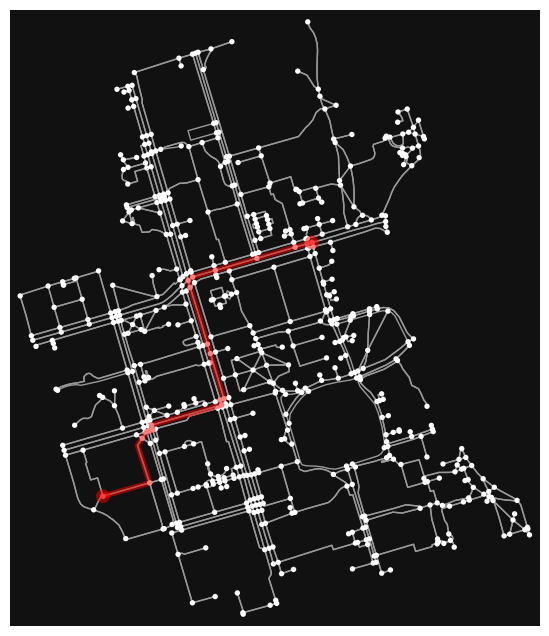

In [16]:
fig, ax = ox.plot_graph_route(G, random_route)

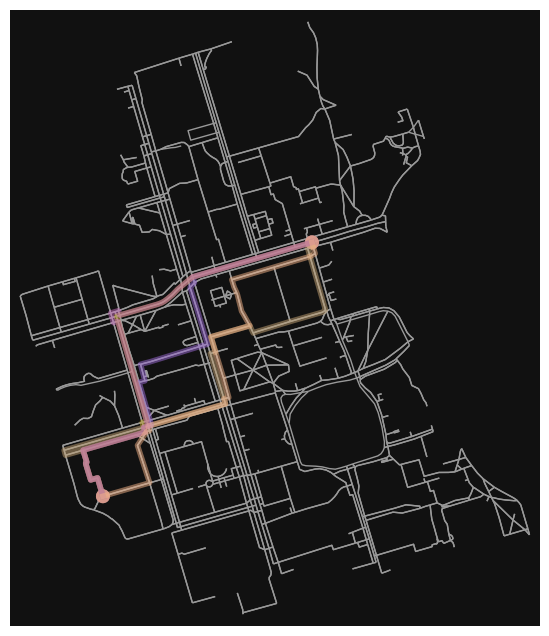

<Figure size 640x480 with 0 Axes>

In [18]:
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color

# generate 5 random routes with 5 different colors -- overlapping routes cancel each other color's
routes = [randomized_search(G, 24959528, 1480794706) for _ in range(5)]
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(5)]
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0)